## Imports

In [26]:
import numpy as np
import scanpy as sc 
import sklearn.metrics as sm
import matplotlib.pyplot as plt

## Data preprocessing

We can obtain our data with or without PCA. Anyway, firstly, let's reduce number of features to 2500.

In [27]:
multiome = sc.read_h5ad("data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
gex = multiome[:, multiome.var["feature_types"] == "GEX"]

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [29]:
gex_data = gex[:, gex.var["highly_variable"]].X
gex_data.shape # should be (90k, 2500)

(90261, 2500)

In [30]:
sc.pp.pca(gex, n_comps=2) # Perform PCA reduction of the data

In [31]:
gex_data_pcaed = np.array(gex.obsm["X_pca"], dtype=np.float32)
gex_data_pcaed.shape # should be (90k, 30)

(90261, 2)

In [32]:
gex_labels = gex.obs["cell_type"]
gex_labels.shape

(90261,)

## Evaluation pipeline

Let's evaluate PCAed data with Leiden clustering. For this, we must use help of AnnData again.

In [33]:
gex_ad_eval = sc.AnnData(gex_data_pcaed)
sc.pp.neighbors(gex_ad_eval, use_rep='X')
sc.tl.leiden(gex_ad_eval, resolution=1, key_added="leiden")

In [34]:
# Get cluster labels as numpy array
gex_ad_eval.obs["leiden"]

0        19
1        11
2        25
3        15
4        30
         ..
90256    77
90257    93
90258     0
90259    27
90260    26
Name: leiden, Length: 90261, dtype: category
Categories (96, object): ['0', '1', '2', '3', ..., '92', '93', '94', '95']

### Visualization

Using UMAP for visualization because Leiden cannot reduce number of dimensions from 30 to 2.

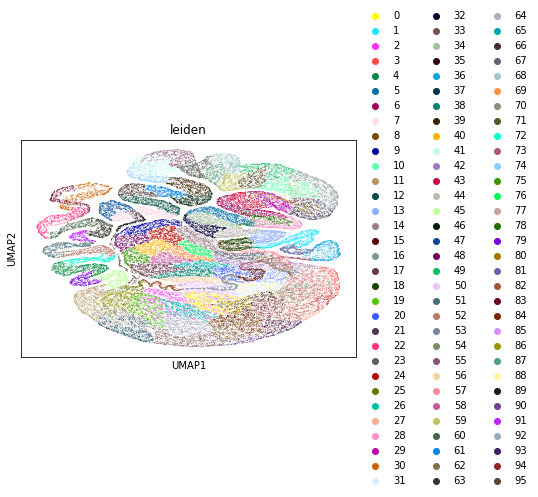

In [35]:
sc.tl.umap(gex_ad_eval)
sc.pl.umap(gex_ad_eval, color="leiden")

In [18]:
ari = sm.adjusted_rand_score(gex_labels.values, gex_ad_eval.obs["leiden"])
ami = sm.adjusted_mutual_info_score(gex_labels.values, gex_ad_eval.obs["leiden"])
homogeneity = sm.homogeneity_score(gex_labels.values, gex_ad_eval.obs["leiden"])
completeness = sm.completeness_score(gex_labels.values, gex_ad_eval.obs["leiden"])
print("""
ARI: {}\n
AMI: {}\n
Homogenuity: {}\n
Completeness: {}
""".format(ari, ami, homogeneity, completeness))


ARI: 0.06248161009715558

AMI: 0.26549472386422207

Homogenuity: 0.30198739490647486

Completeness: 0.24136953972126018

